In [1]:
import torch
import torch.nn as nn
import spconv.pytorch as spconv
from SparseVoxelShuffle import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [238]:
# Function to generate random input indices
def generate_custom_tensor(rows, cols, max_value):
    # Directly generate the full tensor with random integers.
    # First column will be zeroed out to mimic the original logic (if needed).
    tensor = torch.randint(0, max_value + 1, (rows, cols), dtype=torch.int32)
    tensor[:, 0] = 0  # Set the first column to zero if that's a required feature.
    return tensor

def generate_unique_custom_tensors(data_size, cols, max_value):
    seen = set()
    tensors = []
    while len(tensors) < data_size:
        tensor = generate_custom_tensor(1, cols, max_value)
        # Convert tensor to a tuple of tuples for faster comparison and hashable type.
        tensor_tuple = tuple(map(tuple, tensor.tolist()))
        if tensor_tuple not in seen:
            seen.add(tensor_tuple)
            tensors.append(tensor)
    # Concatenate tensors and transfer to CUDA in one operation.
    result = torch.cat(tensors).int()
    if torch.cuda.is_available():
        result = result.cuda()
    return result


In [295]:
# Create a SparseConvTensor
features = torch.randn(3, 24).to(device)  # Example features
indices = generate_unique_custom_tensors(3, 4, 1).to(device)

print(features.shape)
print(indices.shape)

spatial_shape = [2, 2, 2]
batch_size = 1
sparse_tensor = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

torch.Size([3, 24])
torch.Size([3, 4])


In [297]:
voxel_shuffle = VoxelShuffle(upscale_factor=2, pairing_style='strided').to('cuda')
#voxel_unshuffle = VoxelUnshuffle(downscale_factor=2).to('cuda')
print("Before:")
print(sparse_tensor.indices)
print(sparse_tensor.features)

output_0, vs_dict = voxel_shuffle(sparse_tensor)
print("After VS:")
print(output_0.indices)
print(output_0.features)

# output_1 = voxel_unshuffle(output_0)
# print("After UnVS:")
# print(output_1.indices)
# print(output_1.features)

# assert(torch.equal(sparse_tensor.indices.to('cpu'), output_1.indices.to('cpu')))
# assert(torch.equal(sparse_tensor.features.to('cpu'), output_1.features.to('cpu')))


Before:
tensor([[0, 1, 1, 0],
        [0, 1, 1, 1],
        [0, 1, 0, 0]], device='cuda:0', dtype=torch.int32)
tensor([[-0.2180,  0.4342, -0.1865,  0.4968, -0.3860, -0.0868, -0.4157,  0.0382,
         -0.1736,  0.0741, -0.0996, -0.7544,  0.6326,  1.4264, -1.8318,  0.0930,
         -0.2176, -1.0895, -0.2368,  0.1813,  0.5127, -0.5773, -1.7329,  0.1842],
        [-0.0510, -0.4128, -0.7847,  0.6352, -0.1199, -0.8604, -1.3168, -0.3825,
         -0.1952, -0.4065, -0.8856, -0.2084,  0.7076,  2.3894,  1.2303, -0.4214,
         -1.4159,  1.6108, -0.2961,  0.3347, -0.4345, -0.6308,  0.9757,  0.7648],
        [-1.3292, -1.0835,  0.8114,  0.7384,  0.1870,  2.2111,  0.9832,  0.3045,
          0.1313,  0.5057,  1.4238, -0.0700,  0.9134, -0.6982,  0.3729,  1.7236,
          1.0206,  1.0640, -1.7093, -0.3176, -1.1851,  2.1617, -0.1556,  0.1590]],
       device='cuda:0')
After VS:
tensor([[0, 2, 2, 0],
        [0, 2, 3, 0],
        [0, 2, 2, 1],
        [0, 2, 3, 1],
        [0, 3, 2, 0],
        [0, 

In [292]:
print(vs_dict)

{(0, 1, 0, 0): [[0, 2, 0, 0], [0, 2, 1, 0], [0, 2, 0, 1], [0, 2, 1, 1], [0, 3, 0, 0], [0, 3, 1, 0], [0, 3, 0, 1], [0, 3, 1, 1]], (0, 0, 0, 0): [[0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 1, 1]], (0, 0, 0, 1): [[0, 0, 0, 2], [0, 0, 1, 2], [0, 0, 0, 3], [0, 0, 1, 3], [0, 1, 0, 2], [0, 1, 1, 2], [0, 1, 0, 3], [0, 1, 1, 3]]}


In [293]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# Function to plot a single voxel
def plot_voxel(x, y, z, ax, color='r'):
    # Define the vertices of the voxel
    vertices = [[x, y, z],
                [x + 1, y, z],
                [x + 1, y + 1, z],
                [x, y + 1, z],
                [x, y, z + 1],
                [x + 1, y, z + 1],
                [x + 1, y + 1, z + 1],
                [x, y + 1, z + 1]]

    # Define the 6 faces of the voxel
    faces = [[vertices[j] for j in [0, 1, 5, 4]],
             [vertices[j] for j in [7, 6, 2, 3]],
             [vertices[j] for j in [0, 3, 7, 4]],
             [vertices[j] for j in [1, 2, 6, 5]],
             [vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]]]

    poly3d = [[tuple(vertex) for vertex in face] for face in faces]
    collection = Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5)
    ax.add_collection3d(collection)


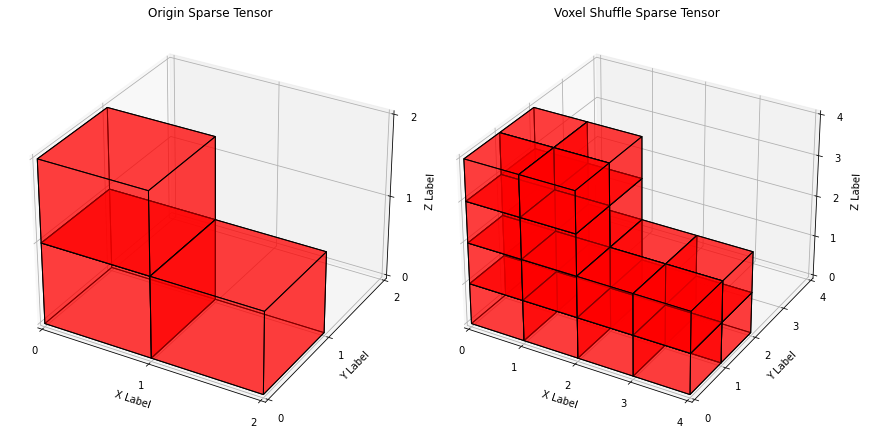

In [294]:
# Create a figure
fig = plt.figure(figsize=(12, 6))

# First subplot for the original sparse tensor
ax1 = fig.add_subplot(121, projection='3d')
coords1 = indices[:, 1:].cpu().numpy()  # Original tensor coordinates
for coord in coords1:
    plot_voxel(coord[0], coord[1], coord[2], ax1)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('Origin Sparse Tensor')
ax1.set_xlim([0, 2])
ax1.set_ylim([0, 2])
ax1.set_zlim([0, 2])
ax1.set_xticks(np.arange(0, 3, 1))
ax1.set_yticks(np.arange(0, 3, 1))
ax1.set_zticks(np.arange(0, 3, 1))

# Second subplot for the voxel shuffle sparse tensor
ax2 = fig.add_subplot(122, projection='3d')
coords2 = output_0.indices[:, 1:].cpu().numpy()  # Voxel shuffled tensor coordinates
for coord in coords2:
    plot_voxel(coord[0], coord[1], coord[2], ax2)
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('Voxel Shuffle Sparse Tensor')
ax2.set_xlim([0, 4])
ax2.set_ylim([0, 4])
ax2.set_zlim([0, 4])
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_yticks(np.arange(0, 5, 1))
ax2.set_zticks(np.arange(0, 5, 1))

# Show the plot
plt.tight_layout()
plt.show()